# Test NN for Entropy Closure #

Test Data is generated from RTSN code

Load all needed modules

In [1]:
# Imports
import pandas as pd
import random                        # for generating random numbers
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt      # MATLAB like plotting routines
from sklearn.preprocessing import normalize

Load and preprocess Training Data

In [2]:
def preprocess_data(filename):
    # reading csv file
    dataFrameInput = pd.read_csv(filename) #outputs a dataframe object

    idx = 0
    xDataList = list()
    yDataList = list()
    data = dataFrameInput.values  # numpy array

    ## Somehow t = 0 has an odd number of elements, just cut it out

    for row in data:
        if (row[2] > 0):
            if (idx % 2 == 0):
                xDataList.append(row)
            else:
                yDataList.append(row)

            idx = idx + 1

    # merge the lists
    DataList = list()
    for rowX, rowY in zip(xDataList, yDataList):
        DataList.append([rowX, rowY])

    # Shuffle data

    random.shuffle(DataList)

    DataArray = np.asarray(DataList)
    #print(DataArray.shape)

    # Strip off header information, i.e. the first 3 cols
    DataArraySlim = DataArray[:, :, 3:]
    #print(DataArraySlim.shape)

    '''
    # split in train and test data (ratio 4:1)
    DataTrain = DataArraySlim[:4 * int(DataArraySlim.shape[0] / 5)]
    DataTest = DataArraySlim[4 * int(DataArraySlim.shape[0] / 5):]

    # Split in x (input) and y (output) data
    xDataTrain = DataTrain[:, 0, :]
    yDataTrain = DataTrain[:, 1, :]
    xDataTest = DataTest[:, 0, :]
    yDataTest = DataTest[:, 1, :]

    #Normalize Input
    #xDataTrain = normalize(xDataTrain, axis=1, norm='l1')
    #xDataTest = normalize(xDataTest, axis=1, norm='l1')
    
    '''
    
    return DataArraySlim

def split_data(Data, ratio): # 0<ratio<1 ratio of test data
    
    # split in train and test data (ratio 4:1)
    DataTrain = Data[:int((1-ratio)* int(Data.shape[0] ))]
    DataTest = Data[int((1-ratio)* int(Data.shape[0] )):]

    # Split in x (input) and y (output) data
    xDataTrain = DataTrain[:, 0, :]
    yDataTrain = DataTrain[:, 1, :]
    xDataTest = DataTest[:, 0, :]
    yDataTest = DataTest[:, 1, :]
    
    return (xDataTrain,yDataTrain,xDataTest,yDataTest)


Review Training Data

In [3]:
# Load the Data
(xDataTrain,yDataTrain,xDataTest,yDataTest) = split_data(preprocess_data("trainNN.csv"),0.2) 


## Start the Neural Network ##
First, load the needed python modules


##Build the Network - Take one: Simple FCN (Fully connected Network) ###

* Input: Solution of the Kinetic solver at time-step n and a cell, called u 
* Output: Legendre multiplier of the entropy closure, called alpha

u and alpha have the same length, which is given by the size of the moment basis.



In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
# Build the network:
def create_model():
  model = tf.keras.models.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(4,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu', input_shape=(64,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu', input_shape=(256,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', input_shape=(128,)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4,)
  ])

  model.summary()
  #plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  '''
  bfgs_opt = tfp.optimizer.bfgs_minimize(
    value_and_gradients_function, initial_position, tolerance=1e-08, x_tolerance=0,
    f_relative_tolerance=0, initial_inverse_hessian_estimate=None,
    max_iterations=50, parallel_iterations=1, stopping_condition=None,
    validate_args=True, max_line_search_iterations=50, name=None
    )
  '''
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])

  return model


### Compile the model ###

In [5]:
model = create_model()

# Let's use the Adam optimizer for learning
#model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1280      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

## Train the model ##


In [6]:
#from tensorflow.keras.callbacks import ReduceLROnPlateau

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)


# Create the model
model = create_model()

'''
history = model.fit(xDataTrain, yDataTrain,validation_split=0.33, epochs=1, batch_size=1000, verbose=1)

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               1280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

"\nhistory = model.fit(xDataTrain, yDataTrain,validation_split=0.33, epochs=1, batch_size=1000, verbose=1)\n\nprint(history.history.keys())\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n# summarize history for loss\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n"

## Evaluate the Model accuracy


In [7]:
score = model.evaluate(xDataTest, yDataTest)
print('Test score:', score[0])
print('Test accuracy:', score[1])

5857/5857 [==============================] - 5s 812us/step - loss: 117.9833 - accuracy: 0.7676
Test score: 117.9832992553711
Test accuracy: 0.767593502998352


##Make a prediction

In [8]:
print(np.asarray([xDataTest[0]]).shape)
pred = model.predict(np.asarray([xDataTest[0]]))
print(pred)

(1, 4)
[[-2.2854481e-04 -6.9507652e-05 -5.4984037e-05  5.2336970e-04]]


## Save trained model

In [9]:
print(tf.version.VERSION)

#!mkdir -p saved_model
#model.save('saved_model/my_model')


2.2.0


In [10]:
# Prepare model for download

#!zip -r model.zip saved_model

In [11]:
# download model
#from google.colab import files
#files.download("model.zip")

## Take two: A more sophisticated Loss Function ##

The Loss is defined as the Objective function of the minimal entropy problem:

$L(u,\alpha, \theta) = <\eta_*(\alpha(\theta) \cdot m(v))>_v - \alpha(\theta) \cdot u$





#### Easiest case 
$\alpha, u\in\mathbb{R}$

Entropy $\eta(\alpha\cdot m) = exp(\alpha\cdot m)$ 

Spherical harmonics basis for $M_0$: $ m_0 = \sqrt{\left(\frac{1}{4\pi}\right)}$

tf.Tensor(37.846815845621244, shape=(), dtype=float64)


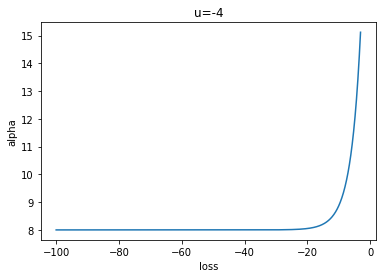

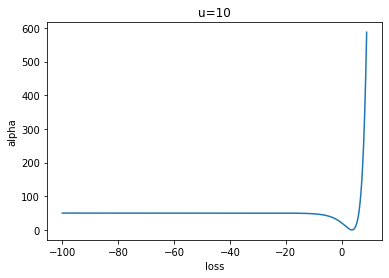

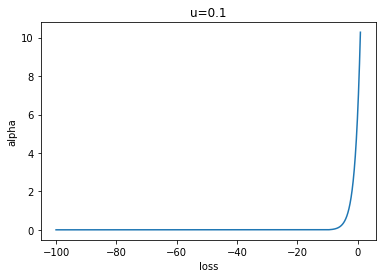

In [12]:
import math

def loss1D(u, alpha):
    return 4*np.pi*np.exp(alpha*np.sqrt(1/(4*np.pi))) - alpha*u

# Custom Loss
def custom_loss1d(u_input, alpha_pred): # (label,prediciton)
     return (0.5*alpha_pred*alpha_pred -u*alpha_pred)
    #return 4*math.pi*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - alpha_pred*u_input

def custom_loss1dMB(u_input, alpha_pred): # (label,prediciton)
    return 4*math.pi*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - alpha_pred*u_input
  
# Custom Loss
def custom_loss1dMBPrime(u_input, alpha_pred): # (label,prediciton)

    return 0.5*tf.square(4*math.pi*np.sqrt(1/(4*np.pi))*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - u_input)
#tf.norm(4*math.pi*np.sqrt(1/(4*np.pi))*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - u_input, ord='euclidean')


# not realizable moment
u = -4
print(custom_loss1dMBPrime(u,1))

alpha = np.arange(-100.0, -3, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=-4')
plt.show()

#realizable moment
u = 10
alpha = np.arange(-100.0, 9.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=10')
plt.show()

# moment close to the boundary of the realizable set
u = 0.1
alpha = np.arange(-100.0, 1.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime(u,alpha))
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=0.1')
plt.show()

In [66]:
# build the network
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

def custom_loss1dMB(u_input, alpha_pred): # (label,prediciton)
    return 4*math.pi*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - alpha_pred*u_input
  
# Custom Loss
def custom_loss1dMBPrime(u_input, alpha_pred): # (label,prediciton)
    return 0.5*tf.square(4*math.pi*np.sqrt(1/(4*np.pi))*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - u_input)

# Custom Loss
def custom_loss1dQuad(u_input, alpha_pred): # (label,prediciton)
    return (0.5*alpha_pred*alpha_pred -u*alpha_pred)
    #return 4*math.pi*tf.math.exp(alpha_pred*np.sqrt(1/(4*np.pi))) - alpha_pred*u_input
  


# Build the network:
def create_model():
    
    # Define the input
    input_ = keras.Input(shape=(1,))
    
    # Hidden layers
    hidden1 = layers.Dense(4, activation="tanh")(input_)  
    hidden2 = layers.Dense(8, activation="tanh")(hidden1)  
    hidden3 = layers.Dense(32, activation="tanh")(hidden2)  
    hidden4 = layers.Dense(8, activation="tanh")(hidden3)  
    hidden5 = layers.Dense(4, activation="tanh")(hidden4)  
    
    #Define the ouput
    output_ = layers.Dense(1)(hidden5)
    
    # Create the model
    model = keras.Model(inputs=[input_], outputs=[output_] )
    
    
    model.summary()
    
    # tf.keras.losses.MeanSquaredError()
    #custom_loss1d
    model.compile(loss=custom_loss1dMBPrime , optimizer='adam',
              metrics=[custom_loss1dMB, custom_loss1dMBPrime])

    return model


In [67]:
model = create_model()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 8         
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_42 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_43 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 5   

In [73]:
# build training data and shuffe!
uTrain = np.arange(0.1, 10,0.000001)
print(uTrain)
random.shuffle(uTrain)
print(uTrain)

[0.1      0.100001 0.100002 ... 9.999997 9.999998 9.999999]
[6.842216 4.260433 9.455449 ... 3.610957 2.044917 0.218258]


### Study of Optimizers ###

Use the dataset np.arange(0.1, 2,0.000001)
* RMSPROP: minimal Loss  4.8240e-05  in 79 epochs
* ADAM:    minimal Loss  1.2580e-06 in 68 epochs
* SGD:  minimal Loss 6.9069e-05 in 167 epochs


[6.842216 4.260433 9.455449 ... 3.610957 2.044917 0.218258]
Epoch 1/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 8.0131e-04 - custom_loss1dMB: 8.2821 - custom_loss1dMBPrime: 8.0131e-04 - val_loss: 2.2021e-04 - val_custom_loss1dMB: 8.2768 - val_custom_loss1dMBPrime: 2.2021e-04
Epoch 2/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 7.0804e-04 - custom_loss1dMB: 8.2820 - custom_loss1dMBPrime: 7.0804e-04 - val_loss: 6.9510e-04 - val_custom_loss1dMB: 8.2771 - val_custom_loss1dMBPrime: 6.9510e-04
Epoch 3/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 6.2810e-04 - custom_loss1dMB: 8.2819 - custom_loss1dMBPrime: 6.2810e-04 - val_loss: 0.0014 - val_custom_loss1dMB: 8.2774 - val_custom_loss1dMBPrime: 0.0014
Epoch 4/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 5.9887e-04 - custom_loss1dMB: 8.2819 - custom_loss1dMBPrime: 5.9887e-04 - val_loss: 8.7748e-04 - val_custom_loss1dMB: 8.2771 - val_custom_loss1d

Epoch 35/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 1.2958e-04 - custom_loss1dMB: 8.2809 - custom_loss1dMBPrime: 1.2958e-04 - val_loss: 2.6511e-05 - val_custom_loss1dMB: 8.2759 - val_custom_loss1dMBPrime: 2.6511e-05
Epoch 36/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 1.2185e-04 - custom_loss1dMB: 8.2809 - custom_loss1dMBPrime: 1.2185e-04 - val_loss: 2.6058e-05 - val_custom_loss1dMB: 8.2759 - val_custom_loss1dMBPrime: 2.6058e-05
Epoch 37/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 1.2933e-04 - custom_loss1dMB: 8.2809 - custom_loss1dMBPrime: 1.2933e-04 - val_loss: 1.3841e-04 - val_custom_loss1dMB: 8.2760 - val_custom_loss1dMBPrime: 1.3841e-04
Epoch 38/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 1.2940e-04 - custom_loss1dMB: 8.2809 - custom_loss1dMBPrime: 1.2940e-04 - val_loss: 2.4939e-05 - val_custom_loss1dMB: 8.2759 - val_custom_loss1dMBPrime: 2.4939e-05
Epoch 39/1500
6930/6930 [===

Epoch 69/1500
6930/6930 [==============================] - 8s 1ms/step - loss: 4.8633e-05 - custom_loss1dMB: 8.2807 - custom_loss1dMBPrime: 4.8633e-05 - val_loss: 2.2934e-05 - val_custom_loss1dMB: 8.2758 - val_custom_loss1dMBPrime: 2.2934e-05
Epoch 70/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 7.0507e-05 - custom_loss1dMB: 8.2808 - custom_loss1dMBPrime: 7.0507e-05 - val_loss: 1.7469e-05 - val_custom_loss1dMB: 8.2758 - val_custom_loss1dMBPrime: 1.7469e-05
Epoch 71/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 5.2971e-05 - custom_loss1dMB: 8.2807 - custom_loss1dMBPrime: 5.2971e-05 - val_loss: 1.7029e-05 - val_custom_loss1dMB: 8.2758 - val_custom_loss1dMBPrime: 1.7029e-05
Epoch 72/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 7.1288e-05 - custom_loss1dMB: 8.2808 - custom_loss1dMBPrime: 7.1288e-05 - val_loss: 1.8611e-05 - val_custom_loss1dMB: 8.2758 - val_custom_loss1dMBPrime: 1.8611e-05
Epoch 73/1500
6930/6930 [===

Epoch 103/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 4.7823e-05 - custom_loss1dMB: 8.2807 - custom_loss1dMBPrime: 4.7823e-05 - val_loss: 1.3577e-05 - val_custom_loss1dMB: 8.2758 - val_custom_loss1dMBPrime: 1.3577e-05
Epoch 104/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 4.0567e-05 - custom_loss1dMB: 8.2807 - custom_loss1dMBPrime: 4.0567e-05 - val_loss: 4.4426e-05 - val_custom_loss1dMB: 8.2758 - val_custom_loss1dMBPrime: 4.4426e-05
Epoch 105/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 4.3046e-05 - custom_loss1dMB: 8.2807 - custom_loss1dMBPrime: 4.3046e-05 - val_loss: 1.3639e-05 - val_custom_loss1dMB: 8.2758 - val_custom_loss1dMBPrime: 1.3639e-05
Epoch 106/1500
6930/6930 [==============================] - 9s 1ms/step - loss: 3.5505e-05 - custom_loss1dMB: 8.2807 - custom_loss1dMBPrime: 3.5505e-05 - val_loss: 1.4507e-05 - val_custom_loss1dMB: 8.2758 - val_custom_loss1dMBPrime: 1.4507e-05
Epoch 107/1500
6930/6930

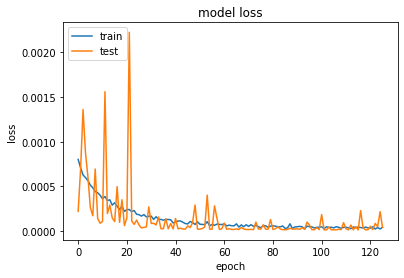

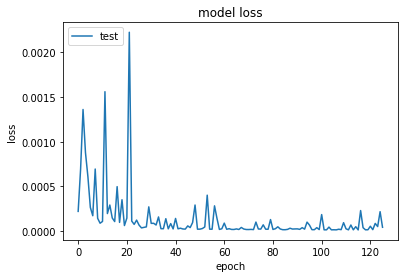

In [75]:
# build training data and shuffe!
#uTrain = np.arange(0.1, 1, 0.000001)
#random.shuffle(uTrain)

# create training data, consiting of only one moment u = 1
#uTrain = np.ones(1000000)
print(uTrain)
#uTrain2 = np.ones(1000000)*2
#uTrain = np.concatenate(uTrain1,uTrain2)

#Create Early Stopping callback
es = EarlyStopping(monitor='loss', mode='min', min_delta =0.00005, patience=50, verbose=10) # loss == custom_loss1dMBPrime by model definition
mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', save_best_only=True)

# use uTrain as labels, since the custom loss is prepared that way 
#,tf.keras.callbacks.History() ,

history = model.fit(uTrain, uTrain,validation_split=0.3, epochs=1500, batch_size=1000, verbose=1, callbacks = [es,mc])

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

[[-4.494337]]


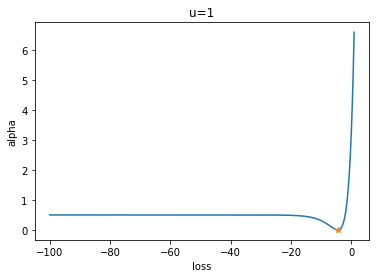

[[-3.0447404]]


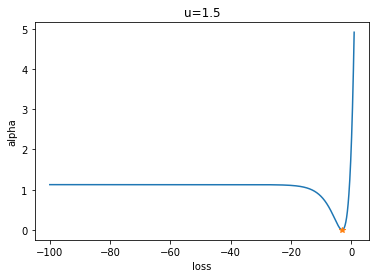

[[-6.951536]]


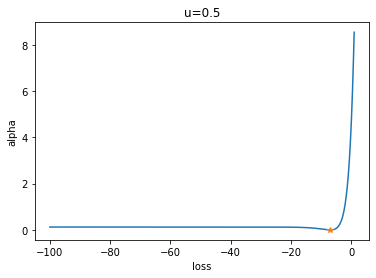

In [70]:
# make prediction
pred = model.predict([1])
print(pred)
# plot prediction to minimal entropy
u = 1
alpha = np.arange(-100.0, 1.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime(u,alpha))
plt.plot(pred,custom_loss1dMBPrime(u,pred), marker="*")
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=1')
plt.show()
# plot prediction to minimal entropy
u = 1.5
pred = model.predict([u])
print(pred)
alpha = np.arange(-100.0, 1.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime(u,alpha))
plt.plot(pred,custom_loss1dMBPrime(u,pred), marker="*")
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=1.5')
plt.show()

u = 0.5
pred = model.predict([u])
print(pred)
alpha = np.arange(-100.0, 1.0, 0.05)
plt.figure()
plt.plot(alpha,custom_loss1dMBPrime(u,alpha))
plt.plot(pred,custom_loss1dMBPrime(u,pred), marker="*")
plt.ylabel('alpha')
plt.xlabel('loss')
plt.title('u=0.5')
plt.show()

In [76]:
# Save the model
print(tf.version.VERSION)

!mkdir -p saved_model
model.save('saved_model/_EntropyLoss_1_10_M_0')

2.2.0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/_EntropyLoss_1_10_M_0/assets


#### Test the model ####

Use alphas computed with a Newton solver

(312354, 1)
(312354, 1)
(0, 1)
(0, 1)
[9.76142e-05 3.35725e+01 9.87153e-05 ... 9.76142e-05 9.76142e-05
 9.76142e-05]


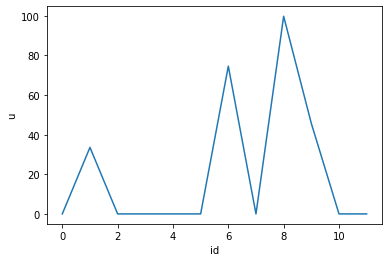

(4,)


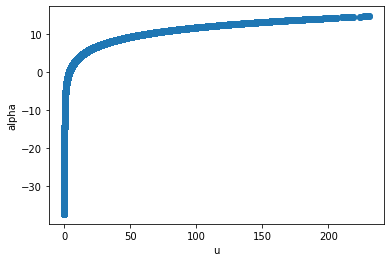

9762/9762 [==============================] - 4s 411us/step - loss: 154.3528 - custom_loss1dMB: 5.2610 - custom_loss1dMBPrime: 154.3528
Test score: 154.35279846191406
Test accuracy: 5.261043071746826
(312354, 1)


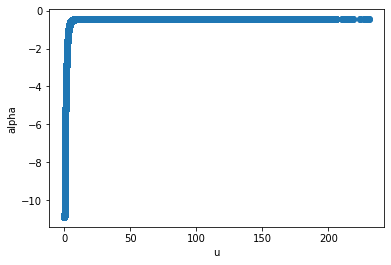

In [71]:
(xDataTrain,yDataTrain,xDataTest,yDataTest)=split_data(preprocess_data("testSetM_0.csv"),0.0)

#Check Test Data
print(xDataTrain.shape)
print(yDataTrain.shape)
print(xDataTest.shape)
print(yDataTest.shape)

print(xDataTrain[:,0])
plt.figure()
plt.plot(xDataTrain[:12])
plt.xlabel('id')
plt.ylabel('u')
plt.show()

x = np.array([1,2,4,5])
y = np.array([1,0,1,0])
print(x.shape)
plt.figure()
plt.plot(xDataTrain[:,0],yDataTrain[:,0], 'o')
plt.xlabel('u')
plt.ylabel('alpha')
plt.show()



score = model.evaluate(np.asarray(xDataTrain), np.asarray(xDataTrain))
print('Test score:', score[0])
print('Test accuracy:', score[1])


pred = model.predict(np.asarray(xDataTrain))
print(pred.shape)

plt.figure()
plt.plot(xDataTrain[:,0],pred[:,0], 'o')
plt.xlabel('u')
plt.ylabel('alpha')
plt.show()

#### The more complicated case ###

In [72]:
## Define the custom loss function
def minimal_Entropy_Loss(u,alpha):

  # Compute the spherical harmonics ( up to degree 2, hardcoded for testing puproses)
  def spherical_harmonics(my, phi):
    m = np.zeros(9)
    m[0] = np.sqrt(1/(4*np.pi))
    
    m[1] = -1* np.sqrt(3/(4*np.pi))*np.sqrt(1-my*my)*np.sin(phi)
    m[2] = np.sqrt(3/(4*np.pi))*my
    m[3] = -1*np.sqrt(3/(4*np.pi))*np.sqrt(1-my*my)*np.cos(phi)

   # m[4] = np.sqrt(15/(16*np.pi)) * (1-my*my) * np.sin(2 * phi)
   # m[5] = -1 * np.sqrt(15/(4*np.pi)) * my * np.sqrt(1-my*my) * sin(phi)
   # m[6] = np.sqrt(5/(16*np.pi))*(3*my*my-1)
   # m[7] = -1 * sqrt(15/(4 * np.pi)) * np.sqrt(1-my * my) * np.cos(phi)
   # m[8] = np.sqrt(15/(16* np.pi))*(1-my * my) * np.cos(2*phi)

  return m

  # Set integration points
  def setPointsWeights(order):
    # legendre points and weights to interpolate my
    (my,w) = np.polynomial.legendre.leggauss(order)

    # points and weights to interpolate phi
    phi = np.zeros(order)
   
    for i in range(0,order):
        phi[i] = (i+0.5)*np.pi/ order

    #tensorized points and weights
    nq =  2 * pow(order, 2 )

    pointsOut = np.zeros([2,nq])
    weightsOut = np.zeros(nq)
    for j in range(0,order):
      for i in range(0,order):
        pointsOut[j * ( 2 * order ) + i,0] = my[j]
        pointsOut[j * ( 2 * order ) + i,1] = phi[i]
        weightsOut[j * ( 2 * order ) + i] = np.pi / order * w[j]

    return (pointsOut,weightsOut)
   
  def entropy_MB(alpha,m):
     return exp(alpa*m)
  # define the entropy part
  def entropy_part(alpha):

    result  = 0.0

    (points ,weights) = setPointsWeights(12) # order 12

    for i in range(0,weights.size):
      m = spherical_harmonics(points[i,0], points[i,1])

      result+=entropyDual(alpha, m)*weights[i]


    return result

  # Stack together the loss function
  loss = entropy_part(alpha) - alpha*u;
  return loss
